# Projections de reports de votes

<div style="text-align: right"> André Mounier </div>

---
Étude des retraits de candidatures

In [1]:
import pandas as pd
import os
import tqdm
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from collections import Counter

pd.options.mode.chained_assignment = None

### Récupération des données de votes
Source : [Ministère de l'intérieur](www.resultats-elections.interieur.gouv.fr)

In [2]:
circonscriptions = pd.read_excel(os.path.join('input','circo_composition.xlsx'), sheet_name='table')
circonscriptions = circonscriptions.drop_duplicates('circo')
circonscriptions = circonscriptions[['DEP','REG','circo']]

Circonscriptions des départements métropolitains et départements d'outre-mer (il manque les 8 circonscriptions des collectivités d'outre-mer et les 11 circonscriptions des Français établis hors de France).

In [3]:
circonscriptions

,DEP,REG,circo
0,01,84,01004
1,01,84,01005
4,01,84,01003
6,01,84,01002
14,01,84,01001
...,...,...,...
35106,974,4,97403
35108,974,4,97404
35110,974,4,97402
35113,974,4,97406


In [4]:
# initialisation du tableau de résultat des votes
results_votes = None
save_path = os.path.join('output','votes_T1')
Path(save_path).mkdir(parents=True, exist_ok=True)
save_name = 'results_votes.csv'

force = True

if save_name not in os.listdir(save_path) or force:
    for i in tqdm.tqdm(range(len(circonscriptions))):
        # données administratives
        dep,reg,circo = circonscriptions[['DEP','REG','circo']].iloc[i].values
        reg = '{:02d}'.format(reg)

        if isinstance(circo, float):
            continue
        
        if circo[2]=='0':
            circo = list(circo)
            circo = circo[:2] + circo[3:]
            circo = ''.join(circo)

        # gestion manuelle des erreurs
        if circo in ['4907']:
            continue
    
        # lien vers les résultats
        url = 'https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/{}/{}/{}/index.html'.format(reg,dep,circo)
        data_candidats, data_votants = pd.read_html(url)
        
        # récupération du nombre d'inscrits, de votants, de blancs, d'exprimés et de nuls
        inscrits, abstentions, votants, blancs, nuls, exprimes = [int(e.replace('\u202f','')) for e in data_votants.Nombre.values]
        
        # données de votes
        data_candidats = data_candidats[['Liste des candidats','Nuance','Voix','Elu(e)']]
        data_candidats['Voix'] = [int(e.replace('\u202f','')) for e in data_candidats.Voix]
        data_candidats['pourcentage_inscrits'] = data_candidats.Voix/inscrits
        data_candidats['pourcentage_exprimes'] = data_candidats.Voix/exprimes
        data_candidats['abstentions'] = [abstentions]*len(data_candidats)
        data_candidats['circo'] = [circo]*len(data_candidats)
        data_candidats['dep'] = [dep]*len(data_candidats)
        data_candidats['reg'] = [reg]*len(data_candidats)
    
        # ajout au tableau de résultat
        if results_votes is None:
            results_votes = data_candidats
        else:
            results_votes = pd.concat([results_votes,data_candidats],ignore_index=True)

    missed = ['https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/52/49/4907/index.html',
              'https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/ZX/ZX01/index.html',
              'https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/975/97501/index.html',
              'https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/988/98801/index.html',
              'https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/988/98802/index.html',
              'https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/987/98701/index.html',
              'https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/987/98702/index.html',
              'https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/987/98703/index.html',
              'https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/986/98601/index.html',
              'https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/06/976/97601/index.html',
              'https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/06/976/97602/index.html']
    
    missed += ['https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/ZZ/ZZ{:02d}/index.html'.format(i) for i in range(1,12)]
    missed += ['https://www.resultats-elections.interieur.gouv.fr/legislatives2024/ensemble_geographique/44/55/55{:02d}/index.html'.format(i) for i in range(1,3)]
    
    for url in tqdm.tqdm(missed):
        dep,reg,circo = url.split('/')[-4:-1]
        data_candidats, data_votants = pd.read_html(url)
        
        # récupération du nombre d'inscrits, de votants, de blancs, d'exprimés et de nuls
        inscrits, abstentions, votants, blancs, nuls, exprimes = [int(e.replace('\u202f','')) for e in data_votants.Nombre.values]
        
        # données de votes
        data_candidats = data_candidats[['Liste des candidats','Nuance','Voix','Elu(e)']]
        data_candidats['Voix'] = [int(e.replace('\u202f','')) for e in data_candidats.Voix]
        data_candidats['pourcentage_inscrits'] = data_candidats.Voix/inscrits
        data_candidats['pourcentage_exprimes'] = data_candidats.Voix/exprimes
        data_candidats['abstentions'] = [abstentions]*len(data_candidats)
        data_candidats['circo'] = [circo]*len(data_candidats)
        data_candidats['dep'] = [dep]*len(data_candidats)
        data_candidats['reg'] = [reg]*len(data_candidats)
    
        # ajout au tableau de résultat
        if results_votes is None:
            results_votes = data_candidats
        else:
            results_votes = pd.concat([results_votes,data_candidats],ignore_index=True)
        
    results_votes = results_votes.reset_index().drop(columns='index')
    results_votes = results_votes.drop_duplicates()
    results_votes.to_csv(os.path.join(save_path, save_name), index=False)
            
results_votes = pd.read_csv(os.path.join(save_path, save_name))
results_votes

100%|███████████████████████████████████████████| 24/24 [00:01<00:00, 22.75it/s]


,Liste des candidats,Nuance,Voix,Elu(e),pourcentage_inscrits,pourcentage_exprimes,abstentions,circo,dep,reg
0,M. Jérôme BUISSON,RN,30221,QUALIF T2,0.314412,0.460069,28539,0104,01,84
1,M. Christophe COQUELET,ENS,14367,QUALIF T2,0.149471,0.218716,28539,0104,01,84
2,Mme Charline LIOTIER,UG,13113,QUALIF T2,0.136425,0.199626,28539,0104,01,84
3,M. Guy BILLOUDET,LR,7179,NON,0.074689,0.109289,28539,0104,01,84
4,M. Sylvain COUSSON,EXG,706,NON,0.007345,0.010748,28539,0104,01,84
...,...,...,...,...,...,...,...,...,...,...
4015,Mme Florence GOULET,RN,19011,OUI,0.320969,0.506271,20631,5502,44,55
4016,M. Jerome DUMONT,DVD,11976,NON,0.202195,0.318926,20631,5502,44,55
4017,M. Johan LAFLOTTE,UG,5391,NON,0.091018,0.143565,20631,5502,44,55
4018,Mme Valentine LAFUE,ECO,742,NON,0.012527,0.019760,20631,5502,44,55


In [5]:
winners = results_votes.groupby('circo')['Voix'].idxmax()
winners_idx = {k:int(v) for k,v in zip(winners.index, winners.values)}
winners_nuance = {k:results_votes.iloc[v]['Nuance'] for k,v in winners.items()}

print('Récupération des résultats de {} circonscriptions sur 577.'.format(len(winners)))

Récupération des résultats de 577 circonscriptions sur 577.


#### Carte des résultats

In [6]:
def draw_blank_map():
    fig = plt.figure(dpi=300, figsize=(6,6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    
    # découpage aux bordures du territoire métropolitain
    ax.set_extent([-5, 9.8, 41.3, 51.3])

    # ajout des frontières et autres éléments
    ax.add_feature(cfeature.OCEAN, color='lightgrey')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.RIVERS, edgecolor='lightgrey', zorder=-2)
    
    return fig,ax

In [7]:
codes_nuances = {'dg':['EXG','DVG'],
                 'fp':['UG','COM','FI','SOC','RDG','VEC','ECO'],
                 'en':['REN','MDM','HOR','ENS','DVC','UDI'],
                 'lr':['LR','DVD'],
                 'rn':['DSV','RN','UXD','EXD'],
                 're':['REC'],
                 'au':['REG','DIV'],
                 'abs':[]}

codes_nuances_inverted = dict()
for k,v in codes_nuances.items():
    for val in v:
        codes_nuances_inverted[val] = k

colors_nuances = {'dg':'tomato',
                  'fp':'tab:red',
                  'en':'tab:orange',
                  'lr':'tab:blue',
                  'rn':'tab:brown',
                  're':'darkblue',
                  'au':'grey',}

In [8]:
circonscriptions_geom = gpd.read_file(os.path.join('input','contours_circonscriptions_legislatives_03052022','circonscriptions_legislatives_030522.shp'))
circonscriptions_geom = circonscriptions_geom.to_crs("epsg:3395")

winners_color = {k:colors_nuances.get(codes_nuances_inverted.get(v)) for k,v in winners_nuance.items()}
circonscriptions_geom['color'] = [winners_color.get(circo, 'w') for circo in circonscriptions_geom.id_circo]

ERROR 1: PROJ: proj_create_from_database: Open of /home/amounier/anaconda3/envs/datan_env/share/proj failed


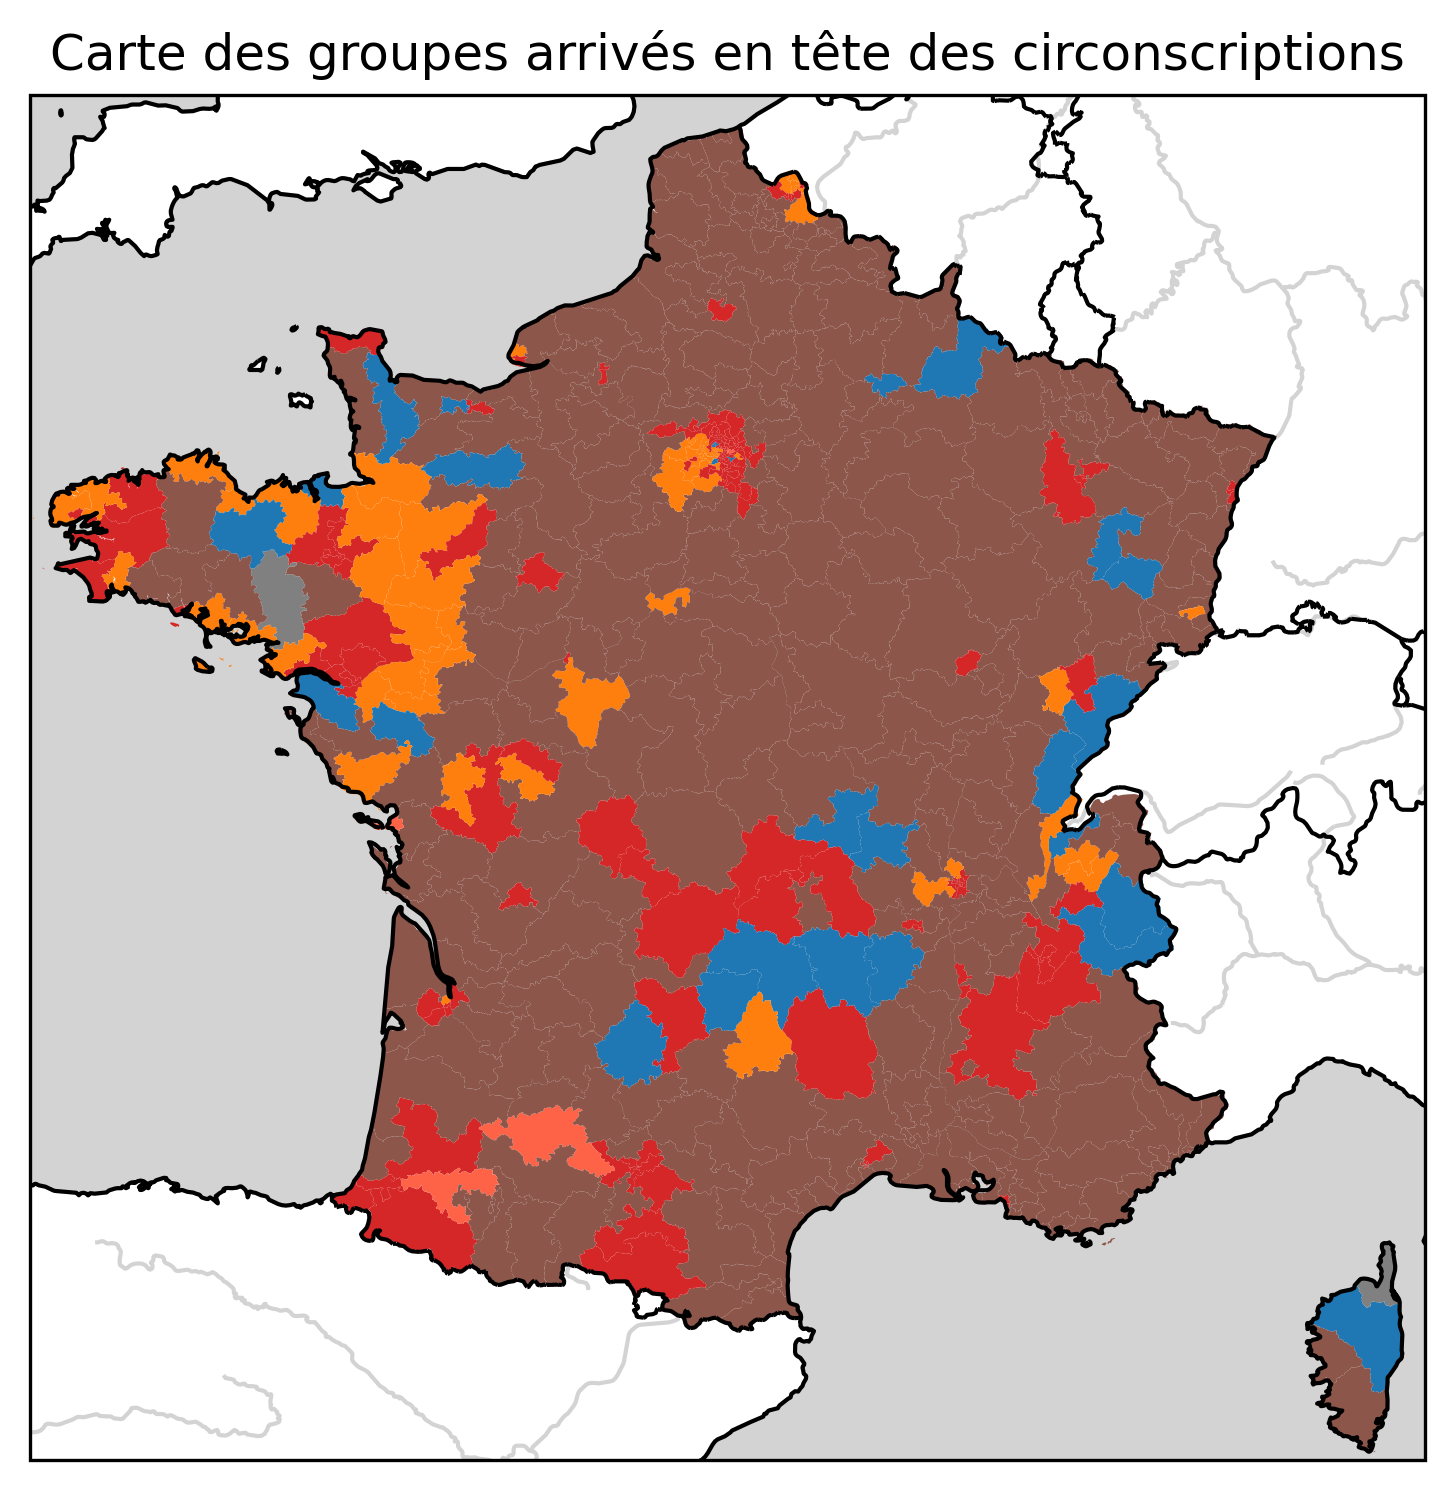

In [9]:
# carte des listes arrivées en tête
fig,ax  = draw_blank_map()
circonscriptions_geom.plot(color=circonscriptions_geom.color, ax=ax)
ax.set_title('Carte des groupes arrivés en tête des circonscriptions')
plt.savefig(os.path.join(save_path, 'carte_votes_T1.png'), bbox_inches='tight')
plt.show()

Échelle des positions des candidats ENS
- 0 : non qualifiés
- 1 : qualifiés en 3ème place
- 2 : qualifiés en 2ème place
- 3 : qualifiés en 1ère place
- 4 : élus au premier tour

In [10]:
position_ens = results_votes.copy()
position_ens['groupe_nuance'] = [codes_nuances_inverted.get(v) for v in position_ens.Nuance]
position_ens
position_ens_dict = dict()

for circo in list(set(position_ens.circo.values)):
    position_ens_circo = position_ens[(position_ens.circo==circo) & (position_ens['Elu(e)'].isin(['QUALIF T2','OUI']))]
    if 'en' not in position_ens_circo.groupe_nuance.values:
        position_ens_dict[circo] = 0
    elif not position_ens_circo[(position_ens_circo.groupe_nuance=='en') & (position_ens_circo['Elu(e)']=='OUI')].empty:
        position_ens_dict[circo] = 4
    else:
        position_ens_dict[circo] = 3-position_ens_circo.groupe_nuance.to_list().index("en")

In [11]:
cmap = plt.colormaps.get_cmap('Blues')
circonscriptions_geom['color'] = [cmap(position_ens_dict.get(circo)/4) for circo in circonscriptions_geom.id_circo]

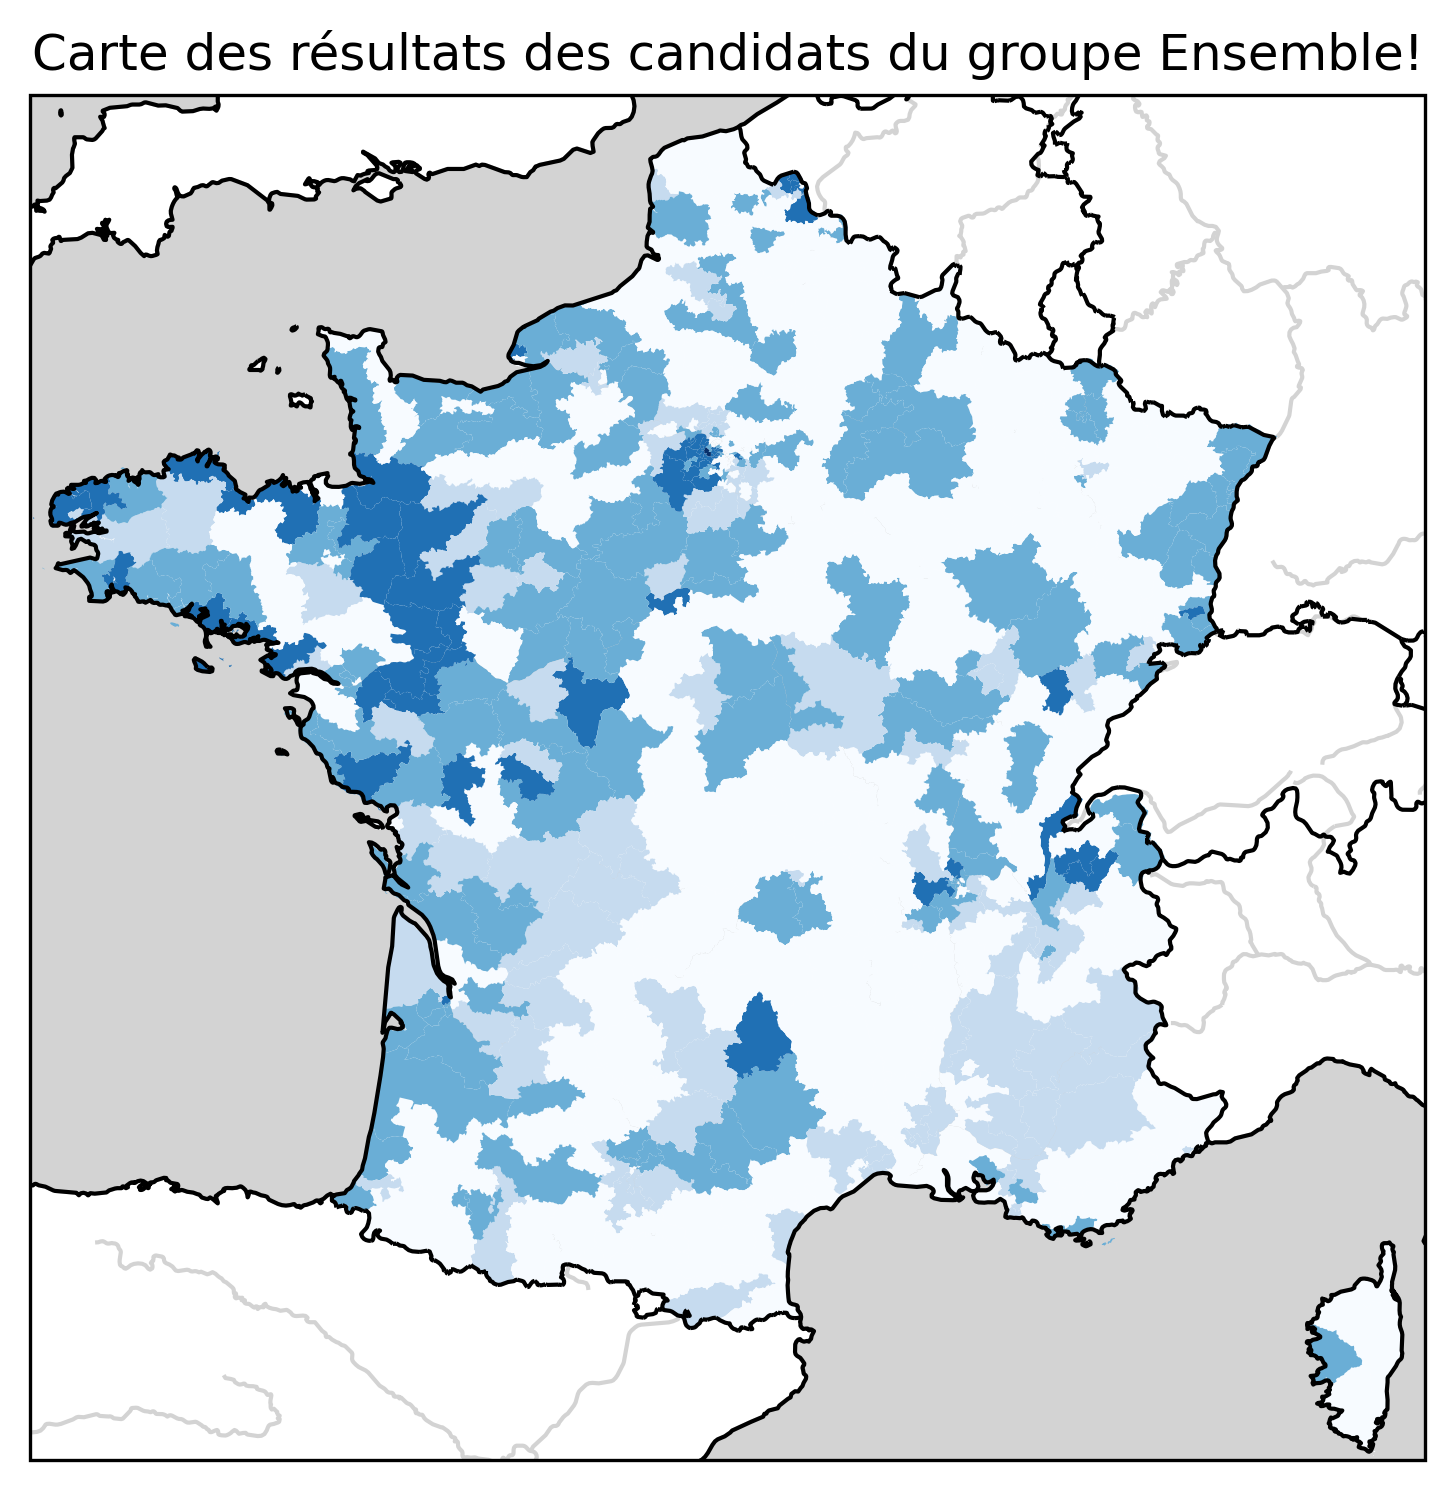

In [12]:
# carte des positions des listes Ensemble!
fig,ax  = draw_blank_map()
circonscriptions_geom.plot(color=circonscriptions_geom.color, ax=ax)
ax.set_title('Carte des résultats des candidats du groupe Ensemble!')
plt.savefig(os.path.join(save_path, 'carte_positions_ENS.png'), bbox_inches='tight')
plt.show()

### Récupération des reports de votes estimés de 2022 
Source : [Harris Interactive](https://harris-interactive.fr/wp-content/uploads/sites/6/2022/06/Harris-x-Toluna-pour-M6-et-RTL-Jour-du-vote-au-2nd-tour-des-elections-legislatives-2022.pdf) (réutilisation dans [Ouest-France](https://www.ouest-france.fr/elections/legislatives/legislatives-2022-nupes-rn-ensemble-comment-s-est-effectue-le-report-des-voix-au-second-tour-47e09e78-f09b-11ec-a1f9-96fad4cda185))

In [13]:
matrix_fp_en = {'fp':{'fp':0.91,'en':0.05,'abs':0.04},
                'dg':{'fp':0.53,'en':0.29,'abs':0.18},
                'en':{'fp':0.02,'en':0.96,'abs':0.02},
                'lr':{'fp':0.09,'en':0.64,'abs':0.27},
                'rn':{'fp':0.24,'en':0.25,'abs':0.51},
                're':{'fp':0.15,'en':0.24,'abs':0.61},
                'au':{'fp':0.33,'en':0.33,'abs':0.33},
               }

matrix_rn_en = {'fp':{'rn':0.24,'en':0.31,'abs':0.45},
                'dg':{'rn':0.36,'en':0.34,'abs':0.30},
                'en':{'rn':0.05,'en':0.92,'abs':0.03},
                'lr':{'rn':0.32,'en':0.49,'abs':0.19},
                'rn':{'rn':0.94,'en':0.02,'abs':0.04},
                're':{'rn':0.83,'en':0.00,'abs':0.17},
                'au':{'fp':0.33,'en':0.33,'abs':0.33},
               }

matrix_fp_rn = {'fp':{'fp':0.89,'rn':0.07,'abs':0.04},
                'dg':{'fp':0.56,'rn':0.17,'abs':0.27},
                'en':{'fp':0.34,'rn':0.18,'abs':0.48},
                'lr':{'fp':0.36,'rn':0.27,'abs':0.37},
                'rn':{'fp':0.04,'rn':0.95,'abs':0.01},
                're':{'fp':0.10,'rn':0.77,'abs':0.13},
                'au':{'fp':0.33,'en':0.33,'abs':0.33},
               }

# ajout d'une matrice dans le cas des triangulaires (ayant lieux dans les scénarios 1 et 4)
matrix_trian = {'fp':{'fp':1.00,'rn':0.00,'en':0.00,'abs':0.00},
                'dg':{'fp':0.70,'rn':0.05,'en':0.10,'abs':0.15},
                'en':{'fp':0.00,'rn':0.00,'en':1.00,'abs':0.00},
                'lr':{'fp':0.20,'rn':0.30,'en':0.30,'abs':0.20},
                'rn':{'fp':0.00,'rn':1.00,'en':0.00,'abs':0.00},
                're':{'fp':0.00,'rn':0.70,'en':0.00,'abs':0.30},
                'au':{'fp':0.30,'rn':0.20,'en':0.30,'abs':0.20},
               }

In [14]:
# sankey diagram

### Projections de votes au second tour

Cinq scénarios testés :
1. Aucun désistement
2. Désistement systématique des candidats NFP arrivés en 3e position
3. Désistement systématique des candidats ENS arrivés en 3e position
4. Désistement systématique des candidats ENS arrivés en 3e position (sauf si LFI)
5. Désistements optimaux pour faire barrage au RN, selon les reports de votes de 2022

In [15]:
save_path = os.path.join('output','votes_T2_projections')
Path(save_path).mkdir(parents=True, exist_ok=True)

##### 1. Aucun désistement

In [16]:
elected = {'dg':0, 'fp':0, 'en':0, 'lr':0, 'rn':0, 're':0, 'au':0,}

circos = list(set(results_votes.circo.values))
circos_T1 = list()
circos_T2 = list()

for circo in tqdm.tqdm(circos):
    results_circo = results_votes[results_votes.circo==circo]
    
    # candidats élus au premier tour
    elected_T1 = results_circo[results_circo['Elu(e)']=='OUI']
    if not elected_T1.empty:
        circos_T1.append(circo)
        groupe_nuance = codes_nuances_inverted.get(elected_T1.Nuance.values[0])
        elected[groupe_nuance] += 1

    # candidats élus au deuxième tour
    else:
        circos_T2.append(circo)
        results_circo['groupe_nuance'] = [codes_nuances_inverted.get(n) for n in results_circo.Nuance.values]
    
        # mise à part des candidats qualifiés
        qualifs = results_circo[results_circo['Elu(e)']=='QUALIF T2']
        qualifs_dict = dict()
        for k,v in zip(qualifs.groupe_nuance, qualifs.Voix):
            if k not in qualifs_dict.keys():
                qualifs_dict[k] = v
            else:
                qualifs_dict[k] += v
    
        # mise à part des candidats non qualifiés
        non_qualifs = results_circo[results_circo['Elu(e)']=='NON']
        non_qualifs_dict = dict()
        for k,v in zip(non_qualifs.groupe_nuance, non_qualifs.Voix):
            if k not in non_qualifs_dict.keys():
                non_qualifs_dict[k] = v
            else:
                non_qualifs_dict[k] += v
    
        # répartition des reports de votes dans le cas de duels
        if len(qualifs)==2:
            if sorted(list(qualifs_dict.keys())) == ['fp','rn']:
                matrix = matrix_fp_rn
            elif sorted(list(qualifs_dict.keys())) == ['en','fp']:
                matrix = matrix_fp_en
            elif sorted(list(qualifs_dict.keys())) == ['en','rn']:
                matrix = matrix_rn_en
    
            reports = dict()
            for groupe, votes in non_qualifs_dict.items():
                rep_frac = matrix.get(groupe)
                rep = {k:int(v*votes) for k,v in rep_frac.items()}
                for gr,vo in rep.items():
                    if gr not in reports.keys():
                        reports[gr] = vo
                    else:
                        reports[gr] += vo
            for k,v in qualifs_dict.items():
                qualifs_dict[k] += reports.get(k,0)
    
        # répartition des reports de votes dans le cas de triangulaires (les coefficients de la matrice sont arbitraires)
        elif len(qualifs)==3:
            matrix = matrix_trian
    
            reports = dict()
            for groupe, votes in non_qualifs_dict.items():
                rep_frac = matrix.get(groupe)
                rep = {k:int(v*votes) for k,v in rep_frac.items()}
                for gr,vo in rep.items():
                    if gr not in reports.keys():
                        reports[gr] = vo
                    else:
                        reports[gr] += vo
            for k,v in qualifs_dict.items():
                qualifs_dict[k] += reports.get(k,0)
    
        elected_T2 = max(qualifs_dict, key=qualifs_dict.get)
        elected[elected_T2] += 1

elected = {k:int(v) for k,v in elected.items() if int(v)>0}

resume = 'Résultats du scénario 1 :'
total = sum(elected.values())
percentage = dict()
sieges = dict()
for gr, vo in elected.items():
    resume += '\n\t- {} : {:>4.1f}% ({:>3}/{})'.format(gr,vo/total*100,vo,total)
    percentage[gr] = vo/total*100
    sieges[gr] = vo
print(resume)

100%|███████████████████████████████████████| 577/577 [00:00<00:00, 1540.85it/s]

Résultats du scénario 1 :
	- dg :  1.9% ( 11/577)
	- fp : 27.0% (156/577)
	- en : 13.0% ( 75/577)
	- lr :  5.0% ( 29/577)
	- rn : 51.6% (298/577)
	- au :  1.4% (  8/577)


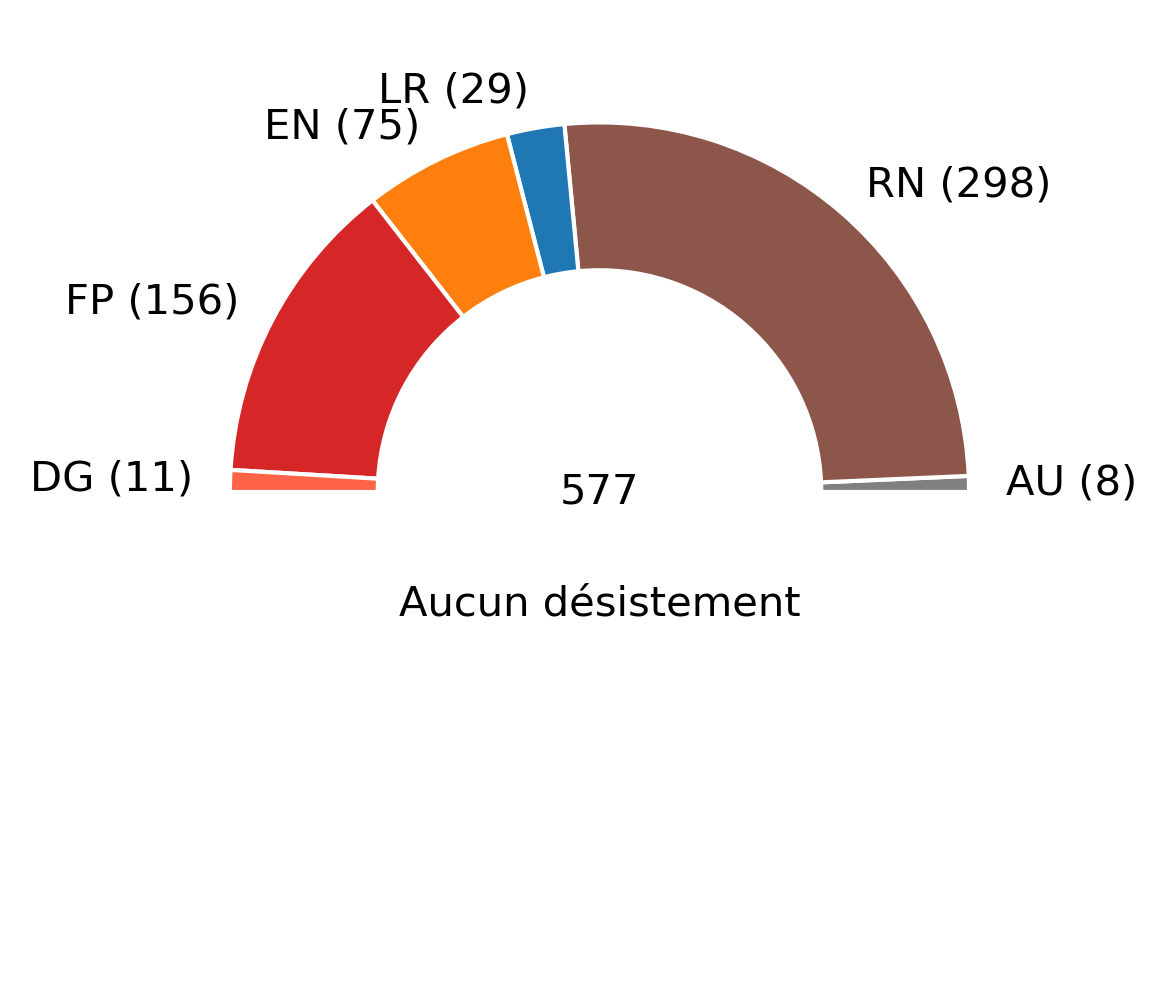

In [17]:
names_nuances = {'dg':'Autres gauches',
                 'fp':'Nouveau Front Populaire',
                 'en':'Ensemble!',
                 'lr':'Les Républicains',
                 'rn':'Rassemblement National',
                 're':'Reconquête',
                 'au':'Autres',}

# plot half pie chart
label = list(elected.keys())[::-1]
val = [elected.get(l) for l in label]
colors = [colors_nuances.get(l) for l in label]

label = ['{} ({})'.format(s.upper(), sieges.get(s)) for s in label]

label.append("")
val.append(sum(val))  # 50% blank
colors.append('white')

fig,ax = plt.subplots(figsize=(10,4),dpi=300)
wedges, labels = plt.pie(val, wedgeprops=dict(width=0.4,edgecolor='w'),labels=label, colors=colors)
wedges[-1].set_visible(False)
ax.margins(x=0, y=5)
ax.text(0.5, 0.5, '577', transform = ax.transAxes, va = 'center', ha = 'center')
ax.text(0.5, 0.4, 'Aucun désistement', transform = ax.transAxes, va = 'top', ha = 'center')
plt.savefig(os.path.join(save_path,'votes_T2_projections_S1.png'),bbox_inches='tight')
plt.show()

##### 2. Désistement systématiques des candidats NFP arrivés 3ème

In [18]:
elected = {'dg':0, 'fp':0, 'en':0, 'lr':0, 'rn':0, 're':0, 'au':0,}

circos = list(set(results_votes.circo.values))
circos_T1 = list()
circos_T2 = list()

for circo in tqdm.tqdm(circos):
    results_circo = results_votes[results_votes.circo==circo]
    
    # candidats élus au premier tour
    elected_T1 = results_circo[results_circo['Elu(e)']=='OUI']
    if not elected_T1.empty:
        circos_T1.append(circo)
        groupe_nuance = codes_nuances_inverted.get(elected_T1.Nuance.values[0])
        elected[groupe_nuance] += 1

    # candidats élus au deuxième tour
    else:
        circos_T2.append(circo)
        results_circo['groupe_nuance'] = [codes_nuances_inverted.get(n) for n in results_circo.Nuance.values]
    
        # mise à part des candidats qualifiés
        qualifs = results_circo[results_circo['Elu(e)']=='QUALIF T2']
        qualifs_dict = dict()
        for k,v in zip(qualifs.groupe_nuance, qualifs.Voix):
            if k not in qualifs_dict.keys():
                qualifs_dict[k] = v
            else:
                qualifs_dict[k] += v

        # retrait des candidats NFP arrivés en 3ème position dans le second tour
        if len(qualifs)==3 and qualifs.groupe_nuance.values[-1]=='fp':
            qualifs = qualifs[qualifs['groupe_nuance']!='fp']
            qualifs_dict = dict()
            for k,v in zip(qualifs.groupe_nuance, qualifs.Voix):
                if k not in qualifs_dict.keys():
                    qualifs_dict[k] = v
                else:
                    qualifs_dict[k] += v
            
            # mise à part des candidats non qualifiés + du candidat NFP
            non_qualifs = results_circo[(results_circo['Elu(e)']=='NON')|(results_circo['groupe_nuance']=='fp')]
            non_qualifs_dict = dict()
            for k,v in zip(non_qualifs.groupe_nuance, non_qualifs.Voix):
                if k not in non_qualifs_dict.keys():
                    non_qualifs_dict[k] = v
                else:
                    non_qualifs_dict[k] += v
            
        else:
            # mise à part des candidats non qualifiés
            non_qualifs = results_circo[results_circo['Elu(e)']=='NON']
            non_qualifs_dict = dict()
            for k,v in zip(non_qualifs.groupe_nuance, non_qualifs.Voix):
                if k not in non_qualifs_dict.keys():
                    non_qualifs_dict[k] = v
                else:
                    non_qualifs_dict[k] += v

        # répartition des reports de votes dans le cas de duels
        if len(qualifs)==2:
            if sorted(list(qualifs_dict.keys())) == ['fp','rn']:
                matrix = matrix_fp_rn
            elif sorted(list(qualifs_dict.keys())) == ['en','fp']:
                matrix = matrix_fp_en
            elif sorted(list(qualifs_dict.keys())) == ['en','rn']:
                matrix = matrix_rn_en
    
            reports = dict()
            for groupe, votes in non_qualifs_dict.items():
                rep_frac = matrix.get(groupe)
                rep = {k:int(v*votes) for k,v in rep_frac.items()}
                for gr,vo in rep.items():
                    if gr not in reports.keys():
                        reports[gr] = vo
                    else:
                        reports[gr] += vo
            for k,v in qualifs_dict.items():
                qualifs_dict[k] += reports.get(k,0)
    
        # répartition des reports de votes dans le cas de triangulaires (les coefficients de la matrice sont arbitraires)
        elif len(qualifs)==3:
            matrix = matrix_trian
    
            reports = dict()
            for groupe, votes in non_qualifs_dict.items():
                rep_frac = matrix.get(groupe)
                rep = {k:int(v*votes) for k,v in rep_frac.items()}
                for gr,vo in rep.items():
                    if gr not in reports.keys():
                        reports[gr] = vo
                    else:
                        reports[gr] += vo
            for k,v in qualifs_dict.items():
                qualifs_dict[k] += reports.get(k,0)
    
        elected_T2 = max(qualifs_dict, key=qualifs_dict.get)
        elected[elected_T2] += 1

elected = {k:int(v) for k,v in elected.items() if int(v)>0}

resume = 'Résultats du scénario 2 :'
total = sum(elected.values())
percentage = dict()
sieges = dict()
for gr, vo in elected.items():
    resume += '\n\t- {} : {:>4.1f}% ({:>3}/{})'.format(gr,vo/total*100,vo,total)
    percentage[gr] = vo/total*100
    sieges[gr] = vo
print(resume)

100%|███████████████████████████████████████| 577/577 [00:00<00:00, 1409.16it/s]

Résultats du scénario 2 :
	- dg :  1.7% ( 10/577)
	- fp : 27.0% (156/577)
	- en : 15.1% ( 87/577)
	- lr :  4.9% ( 28/577)
	- rn : 49.9% (288/577)
	- au :  1.4% (  8/577)


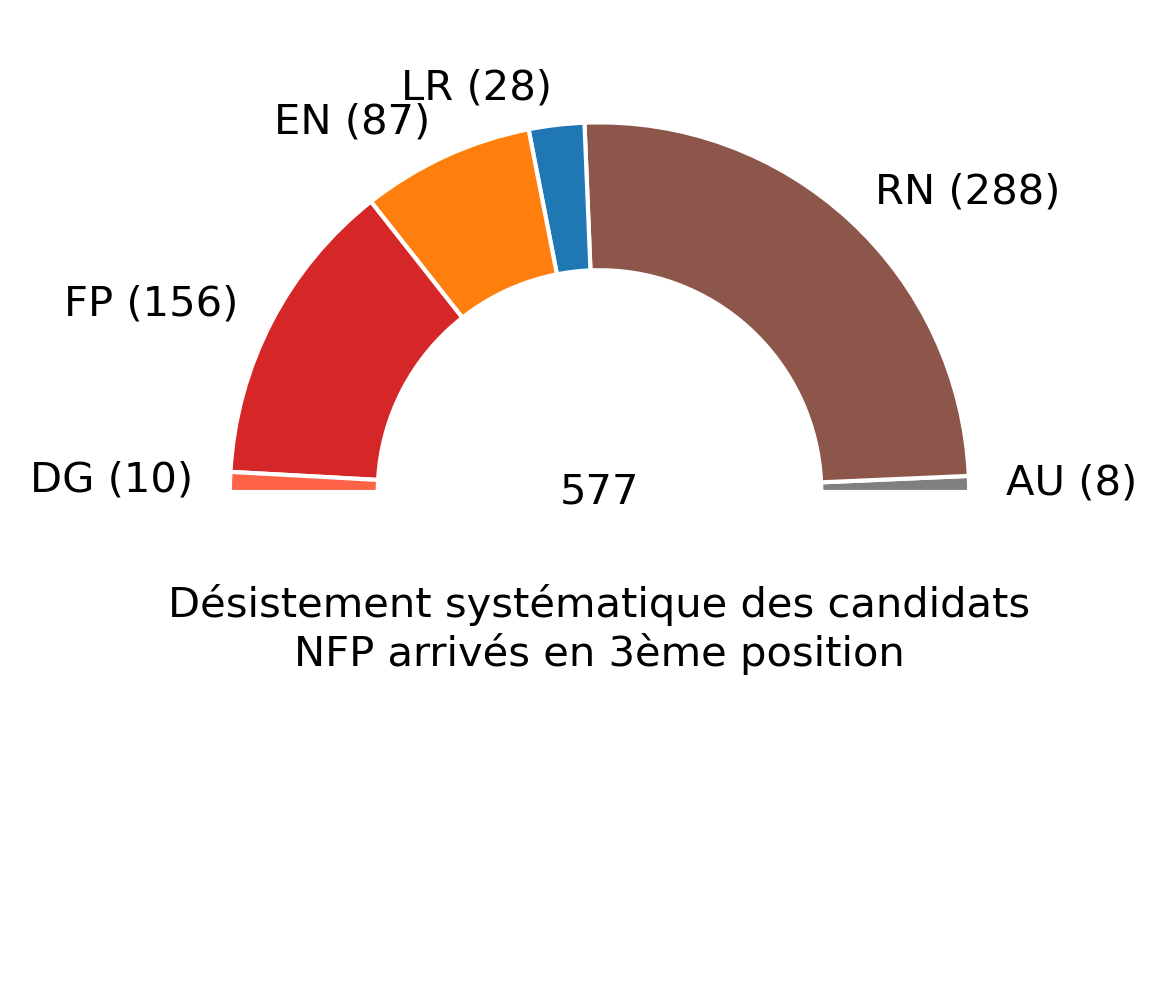

In [19]:
# plot half pie chart
label = list(elected.keys())[::-1]
val = [elected.get(l) for l in label]
colors = [colors_nuances.get(l) for l in label]

label = ['{} ({})'.format(s.upper(), sieges.get(s)) for s in label]

label.append("")
val.append(sum(val))  # 50% blank
colors.append('white')

fig,ax = plt.subplots(figsize=(10,4),dpi=300)
wedges, labels = plt.pie(val, wedgeprops=dict(width=0.4,edgecolor='w'),labels=label, colors=colors)
wedges[-1].set_visible(False)
ax.margins(x=0, y=5)
ax.text(0.5, 0.5, '577', transform = ax.transAxes, va = 'center', ha = 'center')
ax.text(0.5, 0.4, 'Désistement systématique des candidats\nNFP arrivés en 3ème position', transform = ax.transAxes, va = 'top', ha = 'center')
plt.savefig(os.path.join(save_path,'votes_T2_projections_S2.png'),bbox_inches='tight')
plt.show()

##### 3. Désistement systématiques des candidats NFP et ENS arrivés 3ème

In [20]:
elected = {'dg':0, 'fp':0, 'en':0, 'lr':0, 'rn':0, 're':0, 'au':0,}

circos = list(set(results_votes.circo.values))
circos_T1 = list()
circos_T2 = list()

for circo in tqdm.tqdm(circos):
    results_circo = results_votes[results_votes.circo==circo]
    
    # candidats élus au premier tour
    elected_T1 = results_circo[results_circo['Elu(e)']=='OUI']
    if not elected_T1.empty:
        circos_T1.append(circo)
        groupe_nuance = codes_nuances_inverted.get(elected_T1.Nuance.values[0])
        elected[groupe_nuance] += 1

    # candidats élus au deuxième tour
    else:
        circos_T2.append(circo)
        results_circo['groupe_nuance'] = [codes_nuances_inverted.get(n) for n in results_circo.Nuance.values]
    
        # mise à part des candidats qualifiés
        qualifs = results_circo[results_circo['Elu(e)']=='QUALIF T2']
        qualifs_dict = dict()
        for k,v in zip(qualifs.groupe_nuance, qualifs.Voix):
            if k not in qualifs_dict.keys():
                qualifs_dict[k] = v
            else:
                qualifs_dict[k] += v

        # retrait des candidats NFP arrivés en 3ème position dans le second tour
        if len(qualifs)==3 and qualifs.groupe_nuance.values[-1]=='fp':
            qualifs = qualifs[qualifs['groupe_nuance']!='fp']
            qualifs_dict = dict()
            for k,v in zip(qualifs.groupe_nuance, qualifs.Voix):
                if k not in qualifs_dict.keys():
                    qualifs_dict[k] = v
                else:
                    qualifs_dict[k] += v
            
            # mise à part des candidats non qualifiés + du candidat NFP
            non_qualifs = results_circo[(results_circo['Elu(e)']=='NON')|(results_circo['groupe_nuance']=='fp')]
            non_qualifs_dict = dict()
            for k,v in zip(non_qualifs.groupe_nuance, non_qualifs.Voix):
                if k not in non_qualifs_dict.keys():
                    non_qualifs_dict[k] = v
                else:
                    non_qualifs_dict[k] += v

        # retrait des candidats ENS arrivés en 3ème position dans le second tour
        elif len(qualifs)==3 and qualifs.groupe_nuance.values[-1]=='en':
            qualifs = qualifs[qualifs['groupe_nuance']!='en']
            qualifs_dict = dict()
            for k,v in zip(qualifs.groupe_nuance, qualifs.Voix):
                if k not in qualifs_dict.keys():
                    qualifs_dict[k] = v
                else:
                    qualifs_dict[k] += v
            
            # mise à part des candidats non qualifiés + du candidat ENS
            non_qualifs = results_circo[(results_circo['Elu(e)']=='NON')|(results_circo['groupe_nuance']=='en')]
            non_qualifs_dict = dict()
            for k,v in zip(non_qualifs.groupe_nuance, non_qualifs.Voix):
                if k not in non_qualifs_dict.keys():
                    non_qualifs_dict[k] = v
                else:
                    non_qualifs_dict[k] += v
            
        else:
            # mise à part des candidats non qualifiés
            non_qualifs = results_circo[results_circo['Elu(e)']=='NON']
            non_qualifs_dict = dict()
            for k,v in zip(non_qualifs.groupe_nuance, non_qualifs.Voix):
                if k not in non_qualifs_dict.keys():
                    non_qualifs_dict[k] = v
                else:
                    non_qualifs_dict[k] += v

        # répartition des reports de votes dans le cas de duels
        if len(qualifs)==2:
            if sorted(list(qualifs_dict.keys())) == ['fp','rn']:
                matrix = matrix_fp_rn
            elif sorted(list(qualifs_dict.keys())) == ['en','fp']:
                matrix = matrix_fp_en
            elif sorted(list(qualifs_dict.keys())) == ['en','rn']:
                matrix = matrix_rn_en
    
            reports = dict()
            for groupe, votes in non_qualifs_dict.items():
                rep_frac = matrix.get(groupe)
                rep = {k:int(v*votes) for k,v in rep_frac.items()}
                for gr,vo in rep.items():
                    if gr not in reports.keys():
                        reports[gr] = vo
                    else:
                        reports[gr] += vo
            for k,v in qualifs_dict.items():
                qualifs_dict[k] += reports.get(k,0)
    
        # répartition des reports de votes dans le cas de triangulaires (les coefficients de la matrice sont arbitraires)
        elif len(qualifs)==3:
            matrix = matrix_trian
    
            reports = dict()
            for groupe, votes in non_qualifs_dict.items():
                rep_frac = matrix.get(groupe)
                rep = {k:int(v*votes) for k,v in rep_frac.items()}
                for gr,vo in rep.items():
                    if gr not in reports.keys():
                        reports[gr] = vo
                    else:
                        reports[gr] += vo
            for k,v in qualifs_dict.items():
                qualifs_dict[k] += reports.get(k,0)
    
        elected_T2 = max(qualifs_dict, key=qualifs_dict.get)
        elected[elected_T2] += 1

elected = {k:int(v) for k,v in elected.items() if int(v)>0}

resume = 'Résultats du scénario 3 :'
total = sum(elected.values())
percentage = dict()
sieges = dict()
for gr, vo in elected.items():
    resume += '\n\t- {} : {:>4.1f}% ({:>3}/{})'.format(gr,vo/total*100,vo,total)
    percentage[gr] = vo/total*100
    sieges[gr] = vo
print(resume)

100%|███████████████████████████████████████| 577/577 [00:00<00:00, 1335.69it/s]

Résultats du scénario 3 :
	- dg :  1.7% ( 10/577)
	- fp : 29.8% (172/577)
	- en : 14.7% ( 85/577)
	- lr :  4.7% ( 27/577)
	- rn : 47.8% (276/577)
	- au :  1.2% (  7/577)


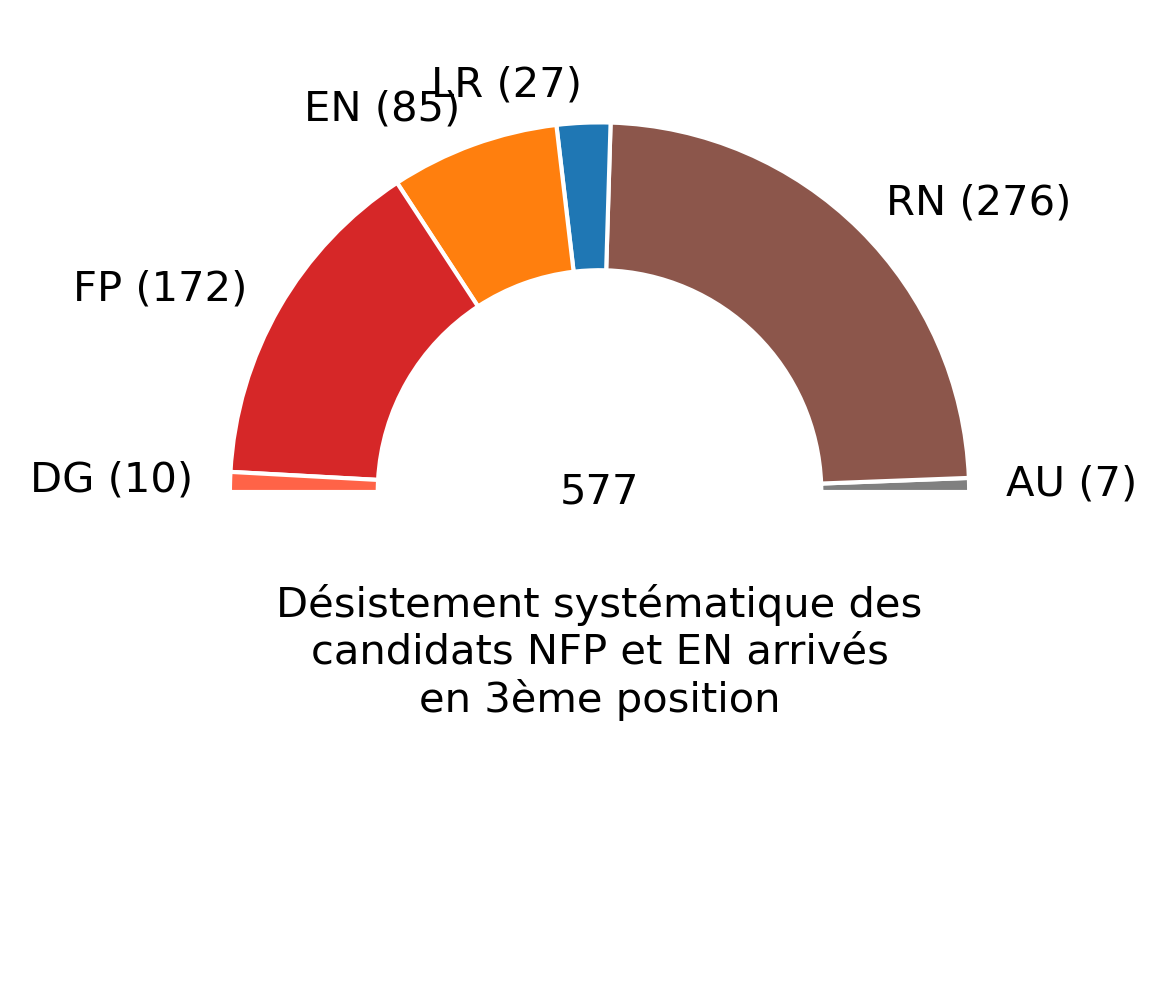

In [21]:
# plot half pie chart
label = list(elected.keys())[::-1]
val = [elected.get(l) for l in label]
colors = [colors_nuances.get(l) for l in label]

label = ['{} ({})'.format(s.upper(), sieges.get(s)) for s in label]

label.append("")
val.append(sum(val))  # 50% blank
colors.append('white')

fig,ax = plt.subplots(figsize=(10,4),dpi=300)
wedges, labels = plt.pie(val, wedgeprops=dict(width=0.4,edgecolor='w'),labels=label, colors=colors)
wedges[-1].set_visible(False)
ax.margins(x=0, y=5)
ax.text(0.5, 0.5, '577', transform = ax.transAxes, va = 'center', ha = 'center')
ax.text(0.5, 0.4, 'Désistement systématique des\ncandidats NFP et EN arrivés\nen 3ème position', transform = ax.transAxes, va = 'top', ha = 'center')
plt.savefig(os.path.join(save_path,'votes_T2_projections_S3.png'),bbox_inches='tight')
plt.show()

##### 4. Désistement systématiques des candidats NFP et ENS (sauf si LFI) arrivés 3ème

In [22]:
# Récupération de la liste des investitures LFI au sein du NFP : https://lafranceinsoumise.fr/2024/06/14/candidats-legislatives-2024/
investitures_lfi_1 = pd.read_html(os.path.join('input','investitures_lfi_2024_1.html'))[0]
investitures_lfi_2 = pd.read_html(os.path.join('input','investitures_lfi_2024_2.html'))[0]
investitures_lfi_3 = pd.read_html(os.path.join('input','investitures_lfi_2024_3.html'))[0]
investitures_lfi = pd.concat([investitures_lfi_1, investitures_lfi_2, investitures_lfi_3], ignore_index=True)
investitures_lfi['Circo'] = [e.replace('-','') for e in investitures_lfi.Circo]
investitures_lfi

,Circo,Numéro de circonscription,Nom du département,Prénom candidat·e,Nom candidat·e,Qualité,Prénom suppléant·e,Nom suppléant·e,Qualité.1
0,0103,3e,Ain,Christian,JOLIE,Candidat,Lisa,WILD,Suppléante
1,0105,5e,Ain,Florence,PISANI,Candidate,Pascal,BAUDET,Suppléant
2,0202,2e,Aisne,Anne-Sophie,DUJANCOURT,Candidate,Didier,LATAPIE,Suppléant
3,0302,2e,Allier,Louise,HÉRITIER,Candidate,Marie-Claude,MONCELON,Suppléant
4,0402,2e,Alpes-de-Haute-Provence,Léo,WALTER,Candidat,Alice,ALLAMEL,Suppléante
...,...,...,...,...,...,...,...,...,...
225,9509,9e,Val-d’Oise,Arnaud,LE GALL,Candidat,Sabrina,BENAÏSSA,Suppléante
226,9510,10e,Val-d’Oise,Aurélien,TACHÉ,Candidat,Daisy,YAÏCH,Suppléante
227,9905,5e,Français résidant à l’étranger,Maxime,DA SILVA,Candidat,Inès,CHEVALIER,Suppléante
228,9907,7e,Français résidant à l’étranger,Asma,RHARMAOUI-CLAQUIN,Candidate,Audrey,LECLERC,Suppléante


In [23]:
liste_circo_lfi = list(investitures_lfi.Circo)

In [24]:
elected = {'dg':0, 'fp':0, 'en':0, 'lr':0, 'rn':0, 're':0, 'au':0,}

circos = list(set(results_votes.circo.values))
circos_T1 = list()
circos_T2 = list()

for circo in tqdm.tqdm(circos):
    results_circo = results_votes[results_votes.circo==circo]
    
    # candidats élus au premier tour
    elected_T1 = results_circo[results_circo['Elu(e)']=='OUI']
    if not elected_T1.empty:
        circos_T1.append(circo)
        groupe_nuance = codes_nuances_inverted.get(elected_T1.Nuance.values[0])
        elected[groupe_nuance] += 1

    # candidats élus au deuxième tour
    else:
        circos_T2.append(circo)
        results_circo['groupe_nuance'] = [codes_nuances_inverted.get(n) for n in results_circo.Nuance.values]
    
        # mise à part des candidats qualifiés
        qualifs = results_circo[results_circo['Elu(e)']=='QUALIF T2']
        qualifs_dict = dict()
        for k,v in zip(qualifs.groupe_nuance, qualifs.Voix):
            if k not in qualifs_dict.keys():
                qualifs_dict[k] = v
            else:
                qualifs_dict[k] += v
        
        # retrait des candidats NFP arrivés en 3ème position dans le second tour
        if len(qualifs)==3 and qualifs.groupe_nuance.values[-1]=='fp':
            qualifs = qualifs[qualifs['groupe_nuance']!='fp']
            qualifs_dict = dict()
            for k,v in zip(qualifs.groupe_nuance, qualifs.Voix):
                if k not in qualifs_dict.keys():
                    qualifs_dict[k] = v
                else:
                    qualifs_dict[k] += v
            
            # mise à part des candidats non qualifiés + du candidat NFP
            non_qualifs = results_circo[(results_circo['Elu(e)']=='NON')|(results_circo['groupe_nuance']=='fp')]
            non_qualifs_dict = dict()
            for k,v in zip(non_qualifs.groupe_nuance, non_qualifs.Voix):
                if k not in non_qualifs_dict.keys():
                    non_qualifs_dict[k] = v
                else:
                    non_qualifs_dict[k] += v
        
        # retrait des candidats ENS arrivés en 3ème position dans le second tour sauf si candidat LFI
        elif len(qualifs)==3 and qualifs.groupe_nuance.values[-1]=='en' and qualifs.circo.values[0] not in liste_circo_lfi:
            qualifs = qualifs[qualifs['groupe_nuance']!='en']
            qualifs_dict = dict()
            for k,v in zip(qualifs.groupe_nuance, qualifs.Voix):
                if k not in qualifs_dict.keys():
                    qualifs_dict[k] = v
                else:
                    qualifs_dict[k] += v
            
            # mise à part des candidats non qualifiés + du candidat ENS
            non_qualifs = results_circo[(results_circo['Elu(e)']=='NON')|(results_circo['groupe_nuance']=='en')]
            non_qualifs_dict = dict()
            for k,v in zip(non_qualifs.groupe_nuance, non_qualifs.Voix):
                if k not in non_qualifs_dict.keys():
                    non_qualifs_dict[k] = v
                else:
                    non_qualifs_dict[k] += v
            
        else:
            # mise à part des candidats non qualifiés
            non_qualifs = results_circo[results_circo['Elu(e)']=='NON']
            non_qualifs_dict = dict()
            for k,v in zip(non_qualifs.groupe_nuance, non_qualifs.Voix):
                if k not in non_qualifs_dict.keys():
                    non_qualifs_dict[k] = v
                else:
                    non_qualifs_dict[k] += v

        # répartition des reports de votes dans le cas de duels
        if len(qualifs)==2:
            if sorted(list(qualifs_dict.keys())) == ['fp','rn']:
                matrix = matrix_fp_rn
            elif sorted(list(qualifs_dict.keys())) == ['en','fp']:
                matrix = matrix_fp_en
            elif sorted(list(qualifs_dict.keys())) == ['en','rn']:
                matrix = matrix_rn_en
    
            reports = dict()
            for groupe, votes in non_qualifs_dict.items():
                rep_frac = matrix.get(groupe)
                rep = {k:int(v*votes) for k,v in rep_frac.items()}
                for gr,vo in rep.items():
                    if gr not in reports.keys():
                        reports[gr] = vo
                    else:
                        reports[gr] += vo
            for k,v in qualifs_dict.items():
                qualifs_dict[k] += reports.get(k,0)
    
        # répartition des reports de votes dans le cas de triangulaires (les coefficients de la matrice sont arbitraires)
        elif len(qualifs)==3:
            matrix = matrix_trian
    
            reports = dict()
            for groupe, votes in non_qualifs_dict.items():
                rep_frac = matrix.get(groupe)
                rep = {k:int(v*votes) for k,v in rep_frac.items()}
                for gr,vo in rep.items():
                    if gr not in reports.keys():
                        reports[gr] = vo
                    else:
                        reports[gr] += vo
            for k,v in qualifs_dict.items():
                qualifs_dict[k] += reports.get(k,0)
    
        elected_T2 = max(qualifs_dict, key=qualifs_dict.get)
        elected[elected_T2] += 1

elected = {k:int(v) for k,v in elected.items() if int(v)>0}

resume = 'Résultats du scénario 4 :'
total = sum(elected.values())
percentage = dict()
sieges = dict()
for gr, vo in elected.items():
    resume += '\n\t- {} : {:>4.1f}% ({:>3}/{})'.format(gr,vo/total*100,vo,total)
    percentage[gr] = vo/total*100
    sieges[gr] = vo
print(resume)

100%|███████████████████████████████████████| 577/577 [00:00<00:00, 1296.72it/s]

Résultats du scénario 4 :
	- dg :  1.7% ( 10/577)
	- fp : 28.6% (165/577)
	- en : 14.9% ( 86/577)
	- lr :  4.7% ( 27/577)
	- rn : 48.9% (282/577)
	- au :  1.2% (  7/577)


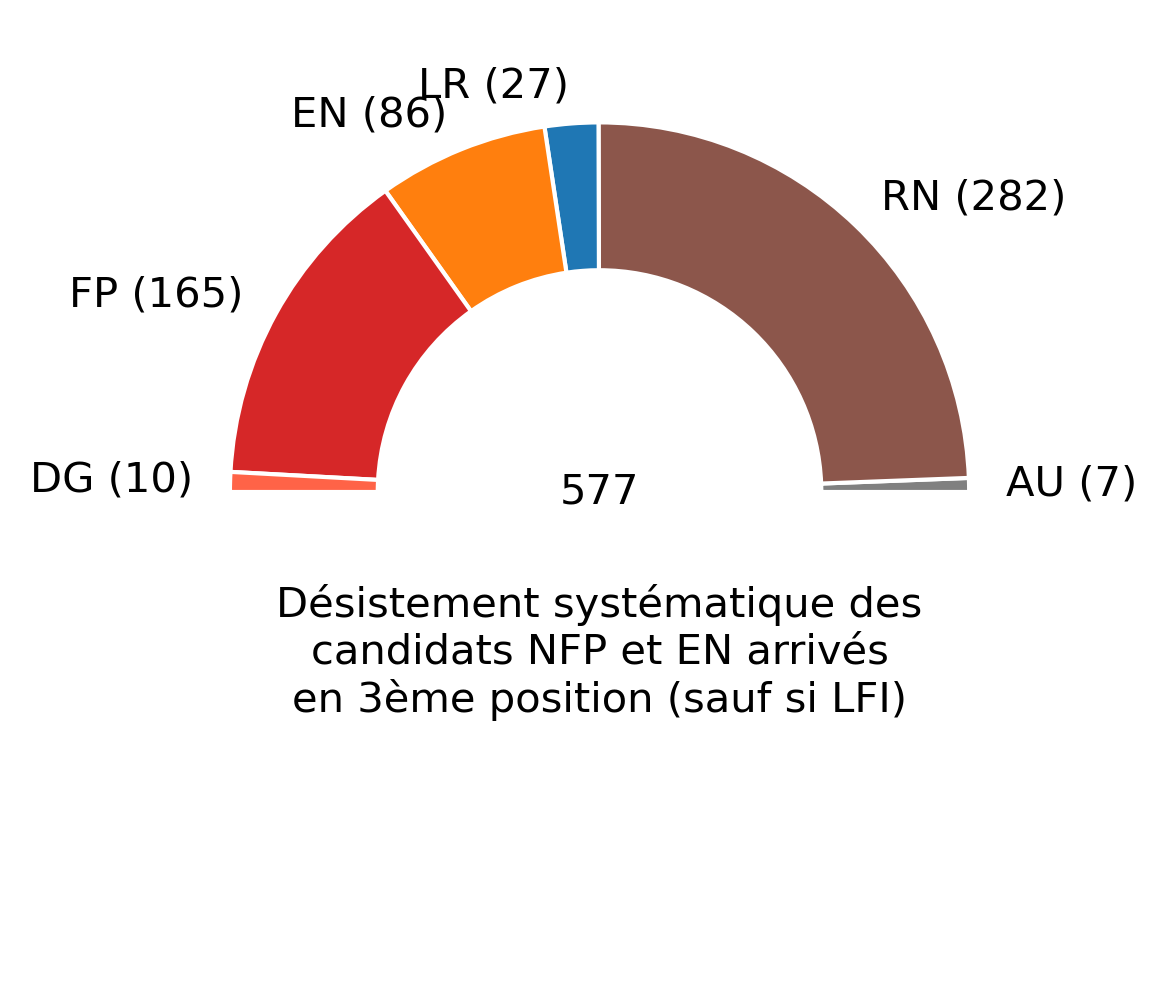

In [25]:
# plot half pie chart
label = list(elected.keys())[::-1]
val = [elected.get(l) for l in label]
colors = [colors_nuances.get(l) for l in label]

label = ['{} ({})'.format(s.upper(), sieges.get(s)) for s in label]

label.append("")
val.append(sum(val))  # 50% blank
colors.append('white')

fig,ax = plt.subplots(figsize=(10,4),dpi=300)
wedges, labels = plt.pie(val, wedgeprops=dict(width=0.4,edgecolor='w'),labels=label, colors=colors)
wedges[-1].set_visible(False)
ax.margins(x=0, y=5)
ax.text(0.5, 0.5, '577', transform = ax.transAxes, va = 'center', ha = 'center')
ax.text(0.5, 0.4, 'Désistement systématique des\ncandidats NFP et EN arrivés\nen 3ème position (sauf si LFI)', transform = ax.transAxes, va = 'top', ha = 'center')
plt.savefig(os.path.join(save_path,'votes_T2_projections_S4.png'),bbox_inches='tight')
plt.show()

##### 5. Désistement optimaux pour limiter les sièges RN

In [29]:
elected = {'dg':0, 'fp':0, 'en':0, 'lr':0, 'rn':0, 're':0, 'au':0,}

circos = list(set(results_votes.circo.values))
circos_T1 = list()
circos_T2 = list()
best_desistement_dict = dict()

for circo in tqdm.tqdm(circos):
    results_circo = results_votes[results_votes.circo==circo]
    
    # candidats élus au premier tour
    elected_T1 = results_circo[results_circo['Elu(e)']=='OUI']
    if not elected_T1.empty:
        circos_T1.append(circo)
        groupe_nuance = codes_nuances_inverted.get(elected_T1.Nuance.values[0])
        elected[groupe_nuance] += 1

    # candidats élus au deuxième tour
    else:
        circos_T2.append(circo)
        results_circo['groupe_nuance'] = [codes_nuances_inverted.get(n) for n in results_circo.Nuance.values]
    
        qualifs = results_circo[results_circo['Elu(e)']=='QUALIF T2']
        qualifs_dict = dict()
        for k,v in zip(qualifs.groupe_nuance, qualifs.Voix):
            if k not in qualifs_dict.keys():
                qualifs_dict[k] = v
            else:
                qualifs_dict[k] += v

        non_qualifs = results_circo[results_circo['Elu(e)']=='NON']
        non_qualifs_dict = dict()
        for k,v in zip(non_qualifs.groupe_nuance, non_qualifs.Voix):
            if k not in non_qualifs_dict.keys():
                non_qualifs_dict[k] = v
            else:
                non_qualifs_dict[k] += v
                    
        if len(qualifs) == 2:
            if sorted(list(qualifs_dict.keys())) == ['fp','rn']:
                matrix = matrix_fp_rn
            elif sorted(list(qualifs_dict.keys())) == ['en','fp']:
                matrix = matrix_fp_en
            elif sorted(list(qualifs_dict.keys())) == ['en','rn']:
                matrix = matrix_rn_en
    
            reports = dict()
            for groupe, votes in non_qualifs_dict.items():
                rep_frac = matrix.get(groupe)
                rep = {k:int(v*votes) for k,v in rep_frac.items()}
                for gr,vo in rep.items():
                    if gr not in reports.keys():
                        reports[gr] = vo
                    else:
                        reports[gr] += vo
            for k,v in qualifs_dict.items():
                qualifs_dict[k] += reports.get(k,0)

            elected_T2 = max(qualifs_dict, key=qualifs_dict.get)

        if len(qualifs) == 3:
            # priorité plate parmi les partis républicains
            priority_order = {'fp':1,'dg':1,'en':1,'lr':1,'au':1,'rn':0,'re':0}
            # priorité prenant en compte la pertinence des programmes
            priority_order = {'fp':10,'dg':9,'en':5,'lr':4,'au':1,'rn':0,'re':0}

            potential_desistement = [e for e in qualifs.groupe_nuance if e != 'rn']
            score = [0]*len(potential_desistement)
            
            for i,d in enumerate(potential_desistement):
                qualifs = results_circo[(results_circo['Elu(e)']=='QUALIF T2')&(results_circo['groupe_nuance']!=d)]
                qualifs_dict = dict()
                for k,v in zip(qualifs.groupe_nuance, qualifs.Voix):
                    if k not in qualifs_dict.keys():
                        qualifs_dict[k] = v
                    else:
                        qualifs_dict[k] += v
        
                non_qualifs = results_circo[(results_circo['Elu(e)']=='NON')|(results_circo['groupe_nuance']==d)]
                non_qualifs_dict = dict()
                for k,v in zip(non_qualifs.groupe_nuance, non_qualifs.Voix):
                    if k not in non_qualifs_dict.keys():
                        non_qualifs_dict[k] = v
                    else:
                        non_qualifs_dict[k] += v

                if sorted(list(qualifs_dict.keys())) == ['fp','rn']:
                    matrix = matrix_fp_rn
                elif sorted(list(qualifs_dict.keys())) == ['en','fp']:
                    matrix = matrix_fp_en
                elif sorted(list(qualifs_dict.keys())) == ['en','rn']:
                    matrix = matrix_rn_en
        
                reports = dict()
                for groupe, votes in non_qualifs_dict.items():
                    rep_frac = matrix.get(groupe)
                    rep = {k:int(v*votes) for k,v in rep_frac.items()}
                    for gr,vo in rep.items():
                        if gr not in reports.keys():
                            reports[gr] = vo
                        else:
                            reports[gr] += vo
                for k,v in qualifs_dict.items():
                    qualifs_dict[k] += reports.get(k,0)
    
                potential_elected_T2 = max(qualifs_dict, key=qualifs_dict.get)
                score[i] = priority_order.get(potential_elected_T2) * qualifs_dict.get(potential_elected_T2)

            best_score_idx = score.index(max(score))
            best_desistement = potential_desistement[best_score_idx]
            best_desistement_dict[circo] = best_desistement

            qualifs = results_circo[(results_circo['Elu(e)']=='QUALIF T2')&(results_circo['groupe_nuance']!=best_desistement)]
            qualifs_dict = dict()
            for k,v in zip(qualifs.groupe_nuance, qualifs.Voix):
                if k not in qualifs_dict.keys():
                    qualifs_dict[k] = v
                else:
                    qualifs_dict[k] += v
    
            non_qualifs = results_circo[(results_circo['Elu(e)']=='NON')|(results_circo['groupe_nuance']==best_desistement)]
            non_qualifs_dict = dict()
            for k,v in zip(non_qualifs.groupe_nuance, non_qualifs.Voix):
                if k not in non_qualifs_dict.keys():
                    non_qualifs_dict[k] = v
                else:
                    non_qualifs_dict[k] += v

            if sorted(list(qualifs_dict.keys())) == ['fp','rn']:
                matrix = matrix_fp_rn
            elif sorted(list(qualifs_dict.keys())) == ['en','fp']:
                matrix = matrix_fp_en
            elif sorted(list(qualifs_dict.keys())) == ['en','rn']:
                matrix = matrix_rn_en
    
            reports = dict()
            for groupe, votes in non_qualifs_dict.items():
                rep_frac = matrix.get(groupe)
                rep = {k:int(v*votes) for k,v in rep_frac.items()}
                for gr,vo in rep.items():
                    if gr not in reports.keys():
                        reports[gr] = vo
                    else:
                        reports[gr] += vo
            for k,v in qualifs_dict.items():
                qualifs_dict[k] += reports.get(k,0)

            elected_T2 = max(qualifs_dict, key=qualifs_dict.get)
            
        elected[elected_T2] += 1
        
elected = {k:int(v) for k,v in elected.items() if int(v)>0}

resume = 'Résultats du scénario 5 :'
total = sum(elected.values())
percentage = dict()
sieges = dict()
for gr, vo in elected.items():
    resume += '\n\t- {} : {:>4.1f}% ({:>3}/{})'.format(gr,vo/total*100,vo,total)
    percentage[gr] = vo/total*100
    sieges[gr] = vo
print(resume)
resume_desistement = '\nNombre de candidats devant se désister :'
counter_desistement = dict(Counter(best_desistement_dict.values()))
for gr, vo in counter_desistement.items():
    resume_desistement += '\n\t- {} : {} candidats'.format(gr,vo)
print(resume_desistement)

100%|████████████████████████████████████████| 577/577 [00:00<00:00, 786.35it/s]

Résultats du scénario 5 :
	- dg :  1.4% (  8/577)
	- fp : 38.6% (223/577)
	- en :  8.3% ( 48/577)
	- lr :  3.5% ( 20/577)
	- rn : 47.0% (271/577)
	- au :  1.2% (  7/577)

Nombre de candidats devant se désister :
	- en : 183 candidats
	- fp : 80 candidats
	- lr : 34 candidats
	- dg : 5 candidats
	- au : 4 candidats


In [30]:
best_desistement_df = None
results_votes['groupe_nuance'] = [codes_nuances_inverted.get(n) for n in results_votes.Nuance.values]
for circo, groupe in best_desistement_dict.items():
    if best_desistement_df is None:
        filtered = results_votes[(results_votes['Elu(e)']=='QUALIF T2') & (results_votes.circo==circo) & (results_votes.groupe_nuance==groupe)]
        best_desistement_df = filtered
    else:
        filtered = results_votes[(results_votes['Elu(e)']=='QUALIF T2') & (results_votes.circo==circo) & (results_votes.groupe_nuance==groupe)]
        best_desistement_df = pd.concat([best_desistement_df,filtered])
best_desistement_df

,Liste des candidats,Nuance,Voix,Elu(e),pourcentage_inscrits,pourcentage_exprimes,abstentions,circo,dep,reg,groupe_nuance
874,M. Jean-François PORTARRIEU,ENS,22267,QUALIF T2,0.204686,0.294331,30528,3105,31,76,en
265,M. Samuel DEGUARA,ENS,14690,QUALIF T2,0.215342,0.305494,17951,1202,12,76,en
630,Mme Magali DUVERNOIS,UG,11804,QUALIF T2,0.180299,0.282649,22529,2504,25,27,fp
912,M. Florian DELRIEU,ENS,12451,QUALIF T2,0.153021,0.223561,24179,3109,31,76,en
697,M. Frédéric DUCHÉ,ENS,14332,QUALIF T2,0.159578,0.243853,29619,2705,27,28,en
...,...,...,...,...,...,...,...,...,...,...,...
3623,M. Guillaume VUILLETET,ENS,13044,QUALIF T2,0.165573,0.253513,26092,9502,95,11,en
3233,M. Alexis IZARD,ENS,20189,QUALIF T2,0.203654,0.298981,29864,9103,91,11,en
860,M. Christophe BEX,UG,24681,QUALIF T2,0.228044,0.331698,31112,3107,31,76,fp
966,Mme Pascale GOT,UG,26631,QUALIF T2,0.216401,0.317864,37023,3305,33,75,fp


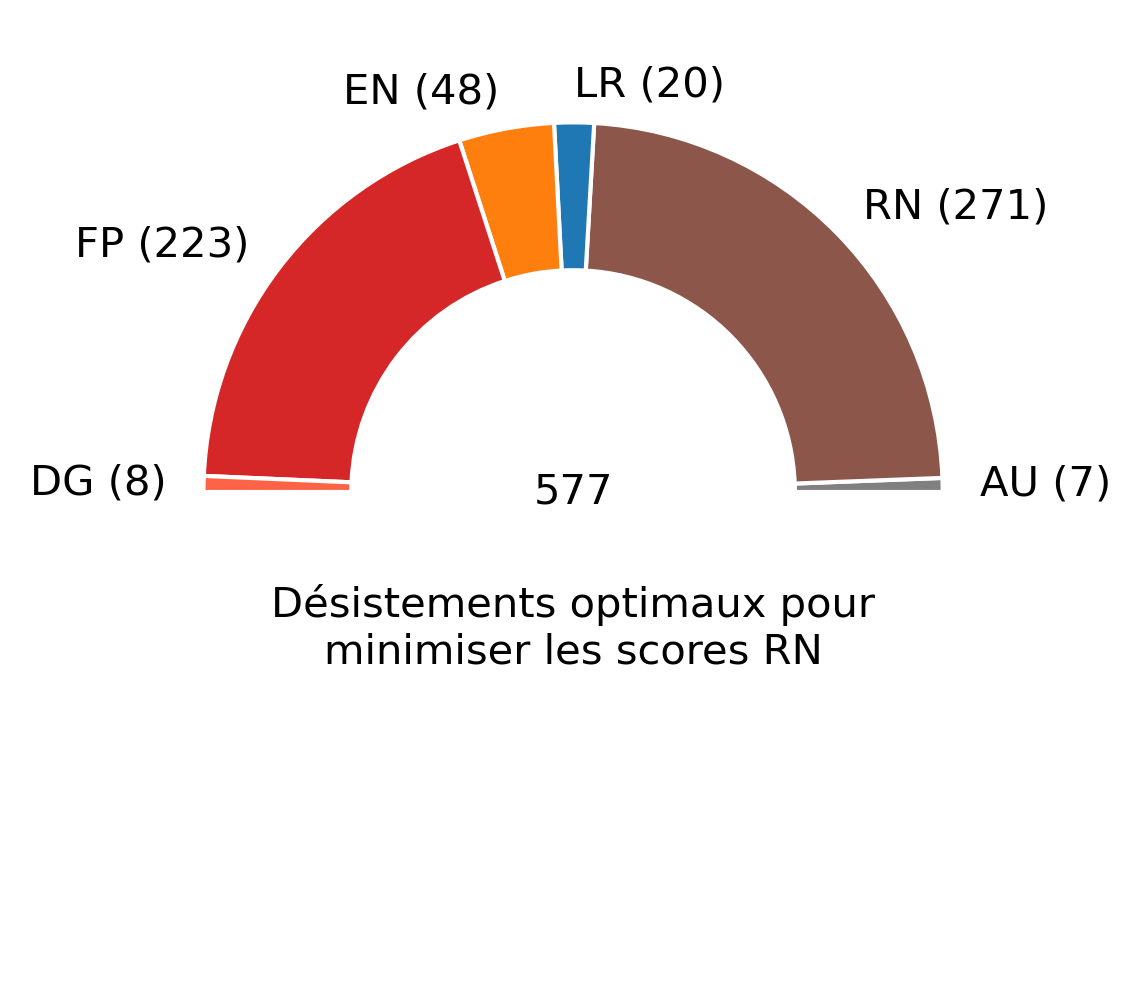

In [31]:
# plot half pie chart
label = list(elected.keys())[::-1]
val = [elected.get(l) for l in label]
colors = [colors_nuances.get(l) for l in label]

label = ['{} ({})'.format(s.upper(), sieges.get(s)) for s in label]

label.append("")
val.append(sum(val))  # 50% blank
colors.append('white')

fig,ax = plt.subplots(figsize=(10,4),dpi=300)
wedges, labels = plt.pie(val, wedgeprops=dict(width=0.4,edgecolor='w'),labels=label, colors=colors)
wedges[-1].set_visible(False)
ax.margins(x=0, y=5)
ax.text(0.5, 0.5, '577', transform = ax.transAxes, va = 'center', ha = 'center')
ax.text(0.5, 0.4, 'Désistements optimaux pour\nminimiser les scores RN', transform = ax.transAxes, va = 'top', ha = 'center')
plt.savefig(os.path.join(save_path,'votes_T2_projections_S5.png'),bbox_inches='tight')
plt.show()